In [1]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import warnings

warnings.filterwarnings("ignore")

# Data Access

## servers, servers everywhere and not a bit to flip

![](https://imgs.xkcd.com/comics/digital_data.png)

# whoami

`ocefpaf` (Filipe Fernandes)

- Physical Oceanographer
- Data Plumber
- Code Janitor
- CI babysitter
- Amazon-Dash-Button for conda-forge

# My day job: IOOS


![](https://raw.githubusercontent.com/ocefpaf/2018-SciPy-talk/gh-pages/images/IOOS-RAs.jpg)

# Big or small we need data!

- There are various sources: variety of servers, APIs, and web services. Just to list a few: OPeNDAP, ERDDAP, THREDDS, ftp, http(s), S3, LAS, etc.

![](https://imgs.xkcd.com/comics/data_pipeline.png)

# Web Services/Type of servers

| Data Type                              | Web Service                       | Response    |
|----------------------------------------|-----------------------------------|-------------|
| In-situ data<br>(buoys, stations, etc) | OGC SOS                           | XML/CSV     |
| Gridded data (models, satellite)       | OPeNDAP                           | Binary      |
| Raster Images                          | OGC WMS                           | GeoTIFF/PNG |
| ERDDAP                                 | Restful API                       | *           |

* You imagination is the limit!

# What are we going to see in this tutorial?
## Browse and access data from:

1. ERDDAP
2. OPeNDAP
3. SOS
4. WMS
5. CSW\*
* Not really a server but a "server" aggregator.

## 1) ERDDAP
## Exploring the IOOS glider DAC server

### Learning objectives:

- Explore an ERDDAP server with the python interface (erddapy);
- Find a glider for a time/region of interest;
- Download the data with a familiar format and create some plots.

## What is ERDDAP?

- Flexible outputs: `.html` table, ESRI `.asc` and `.csv`, Google Earth `.kml`, OPeNDAP binary, `.mat`, `.nc`, ODV `.txt`, `.csvp`, `.tsv`, `.json`, and `.xhtml`
- RESTful API to access the data
- Standardize dates and time in the results
- Server-side searching and slicing

In [2]:
from erddapy import ERDDAP

e = ERDDAP(
    server="https://data.ioos.us/gliders/erddap",
    protocol="tabledap"
)

### What services are available in the server?

In [3]:
import pandas as pd

df = pd.read_csv(
    e.get_search_url(response="csv", search_for="all")
)

In [4]:
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms.'
)

We have 748 tabledap, 0 griddap, and 0 wms.


### Let's query all the datasets that have the "trajectoryprofile" CDM data type.

In [5]:
url = e.get_categorize_url(
    categorize_by="cdm_data_type",
    value="trajectoryprofile",
    response="csv",
)

df = pd.read_csv(url)
dataset_ids = df.loc[
    ~df["tabledap"].isnull(), "Dataset ID"
].tolist()

dataset_ids_list = "\n".join(dataset_ids)
print(f"Found {len(dataset_ids)} datasets")

Found 747 datasets


### Let us narrow our search to deployments that within a lon/lat/time extent.

In [6]:
from ipyleaflet import Map, Rectangle

min_lon, max_lon = -72, -69
min_lat, max_lat = 38, 41

rectangle = Rectangle(
    bounds=((min_lat, min_lon), (max_lat, max_lon))
)

m = Map(
    center=((min_lat + max_lat) / 2,
            (min_lon + max_lon) / 2), zoom=6
)
m.add_layer(rectangle)

In [7]:
m

Map(center=[39.5, -70.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [8]:
kw = {
    "min_time": "2016-07-10T00:00:00Z",
    "max_time": "2017-02-10T00:00:00Z",
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
}

In [9]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
dataset_ids = search["Dataset ID"].values

dataset_ids_list = "\n".join(dataset_ids)

In [10]:
print(f"Found {len(dataset_ids)} Datasets:\n{dataset_ids_list}")

Found 16 Datasets:
blue-20160818T1448
cp_335-20170116T1459
cp_336-20161011T0027
cp_336-20170116T1254
cp_340-20160809T0230
cp_374-20160529T0035
cp_374-20161011T0106
cp_376-20160527T2050
cp_379-20170116T1246
cp_380-20161011T2046
cp_387-20160404T1858
cp_388-20160809T1409
cp_389-20161011T2040
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


In [11]:
e.dataset_id = "whoi_406-20160902T1700"

e.variables = [
    "depth",
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
]

url = e.get_download_url()
print(url)

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.html?depth,latitude,longitude,salinity,temperature,time


In [12]:
import pandas as pd

df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True
).dropna()
df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-02 17:05:38+00:00,6.43,41.120018,-71.017118,32.079258,20.5407
2016-09-02 17:05:38+00:00,7.82,41.120018,-71.017118,32.095406,20.5071
2016-09-02 17:05:38+00:00,8.69,41.120018,-71.017118,32.111920,20.4904
2016-09-02 17:05:38+00:00,9.54,41.120018,-71.017118,32.126587,20.4897
2016-09-02 17:05:38+00:00,10.32,41.120018,-71.017118,32.140717,20.4909


Exercise: experiment with the `e.to_xarray()` method. Think about why/where use one or the other?

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def plot_track(df):
    x = df["longitude (degrees_east)"]
    y = df["latitude (degrees_north)"]
    dx, dy = 2, 4

    fig, ax = plt.subplots(
        figsize=(9, 9), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    cs = ax.scatter(
        x, y, c=df["temperature (Celsius)"], s=50, alpha=0.5, edgecolor="none"
    )
    cbar = fig.colorbar(
        cs, orientation="vertical", fraction=0.1, shrink=0.9, extend="both"
    )
    ax.coastlines("10m")
    ax.set_extent([x.min() - dx, x.max() + dx, y.min() - dy, y.max() + dy])
    return fig, ax

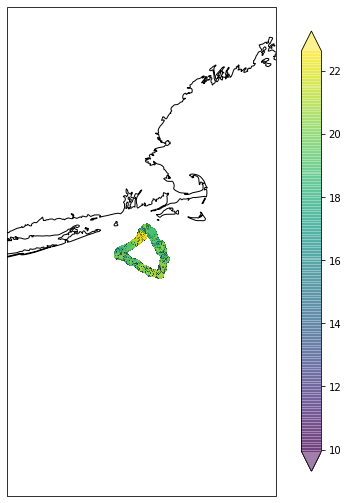

In [14]:
fig, ax = plot_track(df)

In [15]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import palettable
from palettable.cmocean.sequential import Thermal_20

cmap = Thermal_20.mpl_colormap


def plot_glider(df):
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(
        df.index,
        df["depth (m)"],
        s=15,
        c=df["temperature (Celsius)"],
        marker="o",
        edgecolor="none",
        cmap=cmap,
    )

    ax.invert_yaxis()
    xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation="vertical", extend="both")
    cbar.ax.set_ylabel("Temperature ($^\circ$C)")
    ax.set_ylabel("Depth (m)")
    return fig, ax

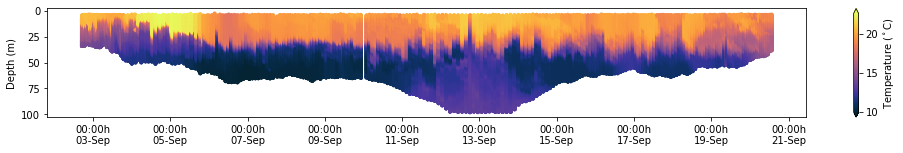

In [16]:
fig, ax = plot_glider(df)

In [17]:
import gsw
import numpy as np


def plot_ts():
    fig, ax = plt.subplots(figsize=(5, 5))

    s = np.linspace(0, 42, 100)
    t = np.linspace(-2, 40, 100)

    s, t = np.meshgrid(s, t)
    sigma = gsw.sigma0(s, t)

    cnt = np.arange(-7, 40, 5)
    cs = ax.contour(s, t, sigma, colors="gray", levels=cnt)
    ax.clabel(cs, fontsize=9, inline=1, fmt="%2i")

    ax.set_xlabel("Salinity [g kg$^{-1}$]")
    ax.set_ylabel("Temperature [$^{\circ}$C]")
    ax.scatter(df["temperature (Celsius)"], df["salinity (1)"], s=10, alpha=0.25)

    ax.grid(True)
    ax.axis([9, 23, 28, 37.5])
    return fig, ax

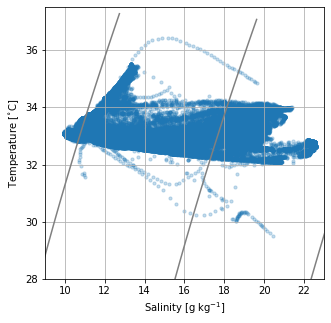

In [18]:
plot_ts();

In [19]:
responses = ["mat", "json", "ncCF", "ncCFHeader"]

for response in responses:
    print(f"{e.get_download_url(response=response)}\n")

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.json?depth,latitude,longitude,salinity,temperature,time

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.ncCF?depth,latitude,longitude,salinity,temperature,time

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.ncCFHeader?depth,latitude,longitude,salinity,temperature,time



Exercise: explore the web interface for the OOI server URL:

https://erddap-uncabled.oceanobservatories.org/uncabled/erddap

or the IOOS glider dac:

https://gliders.ioos.us/erddap

and find a dataset of interested, download a format that you are familiar with and plot it (using the web interface or the Python, your choice).

# 2) OPeNDAP
## Load ocean model data from a THREDDS server

### Learning objectives:

- Open a dataset from an OPeNDAP server with `xarray`;
- Discuss the differences with an `erddapy` request;
- Plot it using `xarray` interface.

In [20]:
import xarray as xr

url = (
    "http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/"
    "fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd"
)
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:      (eta_rho: 181, eta_u: 181, eta_v: 180, ocean_time: 1, time: 3496, xi_rho: 186, xi_u: 185, xi_v: 186, z: 11)
Coordinates:
    lat_rho      (eta_rho, xi_rho) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
    lon_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
  * ocean_time   (ocean_time) datetime64[ns] 2020-03-09
  * z            (z) float64 -250.0 -200.0 -150.0 -100.0 ... -10.0 -5.0 -2.0
  * time         (time) datetime64[ns] 2011-01-02 2011-01-03 ... 2020-07-28
    time_run     (time) datetime64[ns] ...
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables:
    angle        (eta_rho, xi_rho) float64 ...
    h            (eta_rho, xi_rho) float64 ...
    mask_rho     (eta_rho, xi_rho) float64 ...
    mask_u       (eta_u, xi_u) float64 ...
    mask_v       (eta_v, xi_v) float64 ...
    ubar         (time, eta_u, xi_u) float64 ...
    vbar         (time, eta_v, xi_v) float64 ...
    zeta         (time, eta_rho, xi_rho) float64 ...
    temp         (time, z, eta_rho, xi_rho) float32 ...
    salt         (time, z, eta_rho, xi_rho) float32 ...
    rho          (time, z, eta_rho, xi_rho) float32 ...
    u            (time, z, eta_u, xi_u) float32 ...
    v            (time, z, eta_v, xi_v) float32 ...
    w            (time, z, eta_rho, xi_rho) float32 ...
    time_offset  (time) datetime64[ns] ...
Attributes:
    file:                            output/da_fwd_002.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, _Coordinates
    type:                            ROMS/TOMS history file
    title:                           UCSC California Current System, wc12.0_c...
    state_vector:                    zeta, ubar, vbar, u, v, temp, salt
    rst_file:                        output/da_rst.nc
    his_file:                        output/da_fwd_002.nc
    grd_file:                        /proj/ocemod_cencoos_1/ccsrt_v0.2_sys/gr...
    ini_file:                        ncfiles/wc12.0_ini_20200306.nc
    itl_file:                        ncfiles/da_itl.nc
    nrm_file:                        ncfiles/wc12_nrm_i_v7.nc.HAJOON.OLDC_sta...
    obs_file:                        ncfiles/wc12.0_ssh_cmems_hfradar_ucsd_ss...
    frc_file_01:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_02:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_03:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_04:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_05:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_06:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_07:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    bry_file:                        /proj/ocemod_cencoos_1/ccsrt_v0.2_runs/w...
    fwd_file:                        output/da_fwd_001.nc
    script_file:                     
    apar_file:                       is4dvar_phys_only_737jpm_pauls_setup_as_...
    NLM_LBC:                         \nEDGE:  WEST   SOUTH  EAST   NORTH  \nz...
    ADM_LBC:                         \nEDGE:  WEST   SOUTH  EAST   NORTH  \nz...
    svn_url:                         https://www.myroms.org/svn/src/trunk
    svn_rev:                         exported
    code_dir:                        /auto/proj/pmattern/roms/code/roms_737_all
    header_dir:                      /proj/ocemod_cencoos_1/ccsrt_v0.2_sys/ro...
    header_file:                     wc12_ccsra.h
    os:                              Linux
    cpu:                             x86_64
    compiler_system:                 pgi
    compiler_command:                /soft/openmpi_1.10.2/CentOS_6_pgi/bin/mp...
    compiler_flags:                   -O3 -Mfree
    tiling:                  

In [21]:
selection = ds.sel(time="2017-01-01", z=-2.0)
selection

<xarray.Dataset>
Dimensions:      (eta_rho: 181, eta_u: 181, eta_v: 180, ocean_time: 1, xi_rho: 186, xi_u: 185, xi_v: 186)
Coordinates:
    lat_rho      (eta_rho, xi_rho) float64 30.0 30.0 30.0 ... 48.0 48.0 48.0
    lat_u        (eta_u, xi_u) float64 30.0 30.0 30.0 30.0 ... 48.0 48.0 48.0
    lat_v        (eta_v, xi_v) float64 30.05 30.05 30.05 ... 47.95 47.95 47.95
    lon_rho      (eta_rho, xi_rho) float64 -134.0 -133.9 ... -115.6 -115.5
    lon_u        (eta_u, xi_u) float64 -133.9 -133.9 -133.8 ... -115.7 -115.5
    lon_v        (eta_v, xi_v) float64 -134.0 -133.9 -133.8 ... -115.6 -115.5
  * ocean_time   (ocean_time) datetime64[ns] 2020-03-09
    z            float64 -2.0
    time         datetime64[ns] 2017-01-01
    time_run     datetime64[ns] 2017-01-01
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables:
    angle        (eta_rho, xi_rho) float64 0.0004363 0.0004363 ... 0.0006485
    h            (eta_rho, xi_rho) float64 4.497e+03 4.497e+03 ... 10.0 10.0
    mask_rho     (eta_rho, xi_rho) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_u       (eta_u, xi_u) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_v       (eta_v, xi_v) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    ubar         (eta_u, xi_u) float64 ...
    vbar         (eta_v, xi_v) float64 ...
    zeta         (eta_rho, xi_rho) float64 ...
    temp         (eta_rho, xi_rho) float32 ...
    salt         (eta_rho, xi_rho) float32 ...
    rho          (eta_rho, xi_rho) float32 ...
    u            (eta_u, xi_u) float32 ...
    v            (eta_v, xi_v) float32 ...
    w            (eta_rho, xi_rho) float32 ...
    time_offset  datetime64[ns] 2011-01-02
Attributes:
    file:                            output/da_fwd_002.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, _Coordinates
    type:                            ROMS/TOMS history file
    title:                           UCSC California Current System, wc12.0_c...
    state_vector:                    zeta, ubar, vbar, u, v, temp, salt
    rst_file:                        output/da_rst.nc
    his_file:                        output/da_fwd_002.nc
    grd_file:                        /proj/ocemod_cencoos_1/ccsrt_v0.2_sys/gr...
    ini_file:                        ncfiles/wc12.0_ini_20200306.nc
    itl_file:                        ncfiles/da_itl.nc
    nrm_file:                        ncfiles/wc12_nrm_i_v7.nc.HAJOON.OLDC_sta...
    obs_file:                        ncfiles/wc12.0_ssh_cmems_hfradar_ucsd_ss...
    frc_file_01:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_02:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_03:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_04:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_05:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_06:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    frc_file_07:                     /proj/ocemod_cencoos_2/coamps/joined/wc1...
    bry_file:                        /proj/ocemod_cencoos_1/ccsrt_v0.2_runs/w...
    fwd_file:                        output/da_fwd_001.nc
    script_file:                     
    apar_file:                       is4dvar_phys_only_737jpm_pauls_setup_as_...
    NLM_LBC:                         \nEDGE:  WEST   SOUTH  EAST   NORTH  \nz...
    ADM_LBC:                         \nEDGE:  WEST   SOUTH  EAST   NORTH  \nz...
    svn_url:                         https://www.myroms.org/svn/src/trunk
    svn_rev:                         exported
    code_dir:                        /auto/proj/pmattern/roms/code/roms_737_all
    header_dir:                      /proj/ocemod_cencoos_1/ccsrt_v0.2_sys/ro...
    header_file:                     wc12_ccsra.h
    os:                              Linux
    cpu:                             x86_64
    comp

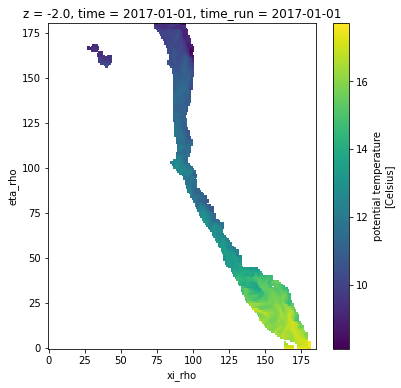

In [22]:
selection["temp"].plot(figsize=(6, 6));

# 3) SOS
## Exploring the CO-OPS SOS API

### Learning objectives:

- Quick explanation on the SOS API.

```python
url = (
    "https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?"
    "service=SOS"
    "&request=GetObservation"
    "&version=1.0.0"
    "&observedProperty=water_surface_height_above_reference"
    "&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000"
    "&responseFormat=text/csv"
    "&eventTime=2018-07-04T00:00:00Z/2018-07-05T00:00:00Z"
    "&result=VerticalDatum==urn:ogc:def:datum:epsg::5103"
    "&dataType=PreliminarySixMinute"
)
```

```python
url = (
    f"https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?"
    f"service=SOS&request={request}"
    f"&version={version}"
    f"&observedProperty={variable}"
    f"&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454000"
    f"&responseFormat={response}"
    f"&eventTime={yesterday:%Y-%m-%dT%H:%M:%SZ}/"
    f"{today:%Y-%m-%dT%H:%M:%SZ}"
    f"&result=VerticalDatum=={vdatum}"
    f"&dataType={data_type}"
)
```

In [23]:
from datetime import datetime, timedelta

variable = "water_surface_height_above_reference_datum"
today = datetime.today()
yesterday = today - timedelta(days=1)

buoy = "8771450"

In [24]:
url = (
    "https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?"
    "service=SOS"
    "&request=GetObservation"
    "&version=1.0.0"
    f"&observedProperty={variable}"
    f"&offering=urn:ioos:station:NOAA.NOS.CO-OPS:{buoy}"
    "&responseFormat=text/csv"
    f"&eventTime={yesterday:%Y-%m-%dT%H:%M:%SZ}/"
    f"{today:%Y-%m-%dT%H:%M:%SZ}"
    "&result=VerticalDatum==urn:ogc:def:datum:epsg::5103"
    "&dataType=PreliminarySixMinute"
)

print(url)

https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=water_surface_height_above_reference_datum&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8771450&responseFormat=text/csv&eventTime=2020-07-31T16:38:25Z/2020-08-01T16:38:25Z&result=VerticalDatum==urn:ogc:def:datum:epsg::5103&dataType=PreliminarySixMinute


In [25]:
import pandas as pd

df = pd.read_csv(url, index_col="date_time", parse_dates=True)
df.head()

,station_id,sensor_id,latitude (degree),longitude (degree),water_surface_height_above_reference_datum (m),datum_id,vertical_position (m),sigma,quality_flags
date_time,,,,,,,,,
2020-07-31 16:42:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.474,urn:ogc:def:datum:epsg::5103,1.43,0.006,1;0;0;0
2020-07-31 16:48:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.484,urn:ogc:def:datum:epsg::5103,1.43,0.006,1;0;0;0
2020-07-31 16:54:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.489,urn:ogc:def:datum:epsg::5103,1.43,0.004,1;0;0;0
2020-07-31 17:00:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.476,urn:ogc:def:datum:epsg::5103,1.43,0.005,1;0;0;0
2020-07-31 17:06:00+00:00,urn:ioos:station:NOAA.NOS.CO-OPS:8771450,urn:ioos:sensor:NOAA.NOS.CO-OPS:8771450:A1,29.31,-94.7933,0.472,urn:ogc:def:datum:epsg::5103,1.43,0.004,1;0;0;0


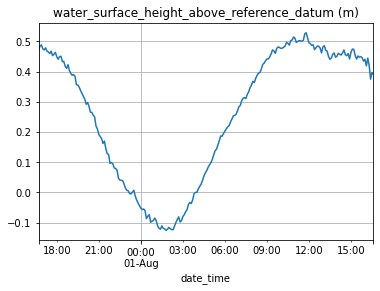

In [26]:
col = df.columns[df.columns.str.startswith(variable)]
ax = df[col].plot.line(legend=False)
ax.grid(True)
ax.set_title(col.values[0]);

In [27]:
from ipyleaflet import Map, Marker

location = df["latitude (degree)"].unique()[0], df["longitude (degree)"].unique()[0]
m = Map(center=location, zoom_start=12)
marker = Marker(location=location)

m.add_layer(marker)

In [28]:
m

Map(center=[29.31, -94.7933], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

# 4) WMS
## Creating a "Hurricane viz widget"
### Learning objectives:

- Add a WMS layer to an interactive map.

In [29]:
from ipyleaflet import Map, WMSLayer, basemaps
from ipywidgets import SelectionSlider
from traitlets import Unicode

time_options = [
    "13:00",
    "13:30",
    "14:00",
    "14:30",
    "15:00",
    "15:30",
    "16:00",
    "16:30",
    "17:00",
    "17:30",
    "18:00",
    "18:30",
]

slider = SelectionSlider(description="Time:", options=time_options)


def update_wms(change):
    time_wms.time = "2020-07-25T{}".format(slider.value)


slider.observe(update_wms, "value")


class TimeWMSLayer(WMSLayer):

    time = Unicode("").tag(sync=True, o=True)


time_wms = TimeWMSLayer(
    url="https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?",
    layers="nexrad-n0r-wmst",
    time="2020-07-25T13:00:00Z",
    format="image/png",
    transparent=True,
    attribution="Weather data © 2012 IEM Nexrad",
)

m = Map(basemap=basemaps.CartoDB.Positron, center=(30, -88), zoom=5)

m.add_layer(time_wms)

In [30]:
m

Map(center=[30, -88], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [31]:
slider

SelectionSlider(description='Time:', options=('13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '…

# 5) Catalog Service Web (CSW)
# Is there a canonical source for data?

![](https://i.kym-cdn.com/photos/images/newsfeed/001/093/557/142.gif)

## Well, kind of... The closet thing is the IOOS CSW catalog.

For more info please see [https://data.ioos.us/](https://data.ioos.us/)

# Catalog Service for the Web (CSW)

- A single source to find endpoints
- Nice python interface:<br>`owslib.csw.CatalogueServiceWeb`
- Advanced filtering:<br>`owslib.fes`

![](https://raw.githubusercontent.com/ocefpaf/2018-SciPy-talk/gh-pages/images/IOOS.svg)

In [32]:
from datetime import datetime

min_lat, max_lat = 20, 30
min_lon, max_lon = -82, -97
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = "urn:ogc:def:crs:OGC:1.3:CRS84"

# Temporal range of 1 week.
start = datetime(2017, 4, 14, 0, 0, 0)
stop = datetime(2017, 4, 21, 0, 0, 0)

# Sea surface temperature CF names.
cf_names = [
    "sea_water_temperature",
    "sea_surface_temperature",
    "sea_water_potential_temperature",
    "equivalent_potential_temperature",
    "sea_water_conservative_temperature",
    "pseudo_equivalent_potential_temperature",
]

In [33]:
def fes_date_filter(start, stop, constraint="overlaps"):
    from owslib import fes

    start = start.strftime("%Y-%m-%d %H:00")
    stop = stop.strftime("%Y-%m-%d %H:00")
    if constraint == "overlaps":
        propertyname = "apiso:TempExtent_begin"
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname, literal=stop)
        propertyname = "apiso:TempExtent_end"
        end = fes.PropertyIsGreaterThanOrEqualTo(
            propertyname=propertyname, literal=start
        )
    elif constraint == "within":
        propertyname = "apiso:TempExtent_begin"
        begin = fes.PropertyIsGreaterThanOrEqualTo(
            propertyname=propertyname, literal=start
        )
        propertyname = "apiso:TempExtent_end"
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname, literal=stop)
    else:
        raise NameError(f"Unrecognized constraint {constraint}")
    return begin, end

In [34]:
from owslib import fes

kw = dict(wildCard="*", escapeChar="\\", singleChar="?", propertyname="apiso:AnyText")

or_filt = fes.Or([fes.PropertyIsLike(literal=("*%s*" % val), **kw) for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And(
        [
            bbox_crs,
            begin,
            end,
            or_filt,
            fes.Not([fes.PropertyIsLike(literal="*cdip*", **kw)]),
        ]
    )
]

In [35]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty

    # Iterate over sorted results.
    sortby = SortBy([SortProperty("dc:title", "ASC")])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, "results", 1)
    while nextrecord != 0:
        csw.getrecords2(
            constraints=filter_list,
            startposition=startposition,
            maxrecords=pagesize,
            sortby=sortby,
        )
        csw_records.update(csw.records)
        if csw.results["nextrecord"] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [36]:
from owslib.csw import CatalogueServiceWeb

endpoint = "https://data.ioos.us/csw"
csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)
records = "\n".join(csw.records.keys())
print("Found {} records.\n".format(len(csw.records.keys())))

Found 176 records.



In [37]:
import textwrap

key, value = list(csw.records.items())[-1]
print("\n".join(textwrap.wrap(value.abstract)))

NOAA.NOS.CO-OPS Sensor Observation Service (SOS) Server  This station
provides the following variables: Direction of sea water velocity,
Platform orientation, Platform pitch angle, Platform roll angle, Sea
water speed, Sea water temperature


In [38]:
from geolinks import sniff_link

msg = "geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n".format
for ref in value.references:
    print(msg(geolink=sniff_link(ref["url"]), **ref))

geolink: OGC:SOS
scheme: Old Port Tampa
URL: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"&version=1.0.0&procedure=urn:ioos:station:NOAA.NOS.CO-OPS:t02010&service=SOS

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:t02010&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/direction_of_sea_water_velocity&responseFormat=text/csv&eventTime=2020-04-23T16:10:17/2020-04-23T18:10:17&service=SOS

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:t02010&version=1.0.0&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/platform_orientation&responseFormat=text/csv&eventTime=2020-04-23T16:10:17/2020-04-23T18:10:17&service=SOS

geolink: OGC:SOS
scheme: WW

## For more complex examples on how to find data in the catalog please check the [IOOS code gallery](https://ioos.github.io/notebooks_demos/code_gallery).

# Where to find data?

## Curated list of ERDDAP servers

https://github.com/IrishMarineInstitute/awesome-erddap


## Environmental Data Service (EDS) model viewer

https://eds.ioos.us


## Exploring THREDDS servers

https://unidata.github.io/siphon/latest

# Extras: load netCDF files directly from HTTP

In [39]:
from netCDF4 import Dataset

try:
    url = "https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPC/2019/027/00/OR_ABI-L2-CMIPC-M3C01_G16_s20190270002156_e20190270004529_c20190270004598.nc"
    nc = Dataset(url)
except OSError as e:
    print(e)

[Errno -90] NetCDF: file not found: b'https://noaa-goes16.s3.amazonaws.com/ABI-L2-CMIPC/2019/027/00/OR_ABI-L2-CMIPC-M3C01_G16_s20190270002156_e20190270004529_c20190270004598.nc'


In [40]:
with Dataset(f"{url}#mode=bytes") as nc:
    print(nc.summary)

Single reflective band Cloud and Moisture Imagery Products are digital maps of clouds, moisture, and atmospheric windows at visible and near-IR bands.


![](https://media.giphy.com/media/12NUbkX6p4xOO4/giphy.gif)

# Extras: custom APIs like CSD

For more info see [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [41]:
import cdsapi

c = cdsapi.Client()

name = "reanalysis-era5-pressure-levels"
request = {
    "year": "2008",
    "month": "01",
    "day": "01",
    "time": "12:00",
    "variable": "temperature",
    "pressure_level": "1000",
    "product_type": "reanalysis",
    "format": "netcdf",
}

r = c.retrieve(name, request, None)

2020-08-01 16:39:23,575 INFO Welcome to the CDS
2020-08-01 16:39:23,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-08-01 16:39:26,035 INFO Request is completed


In [42]:
r.location

'http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1595873490.7537935-7526-21-250a76f9-7d43-4658-a81b-5149a014806e.nc'

In [43]:
import xarray as xr

ds = xr.open_dataset(f"{r.location}#mode=bytes")
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01T12:00:00
Data variables:
    t          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-27 18:11:31 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

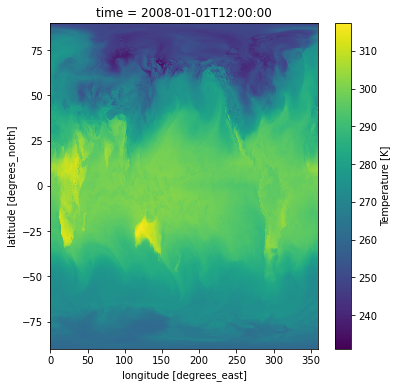

In [44]:
temp = ds["t"].squeeze()
temp.plot(figsize=(6, 6))

# Extras: how does this all work?

## Standards!

![](https://imgs.xkcd.com/comics/standards.png)

# Bad example

In [45]:
import cftime
import nc_time_axis
from netCDF4 import Dataset

url = "http://goosbrasil.org:8080/pirata/B19s34w.nc"
nc = Dataset(url)

temp = nc["temperature"][:]
times = nc["time"]
temp[temp <= -9999] = np.NaN
t = cftime.num2date(times[:], times.units, calendar=times.calendar,)

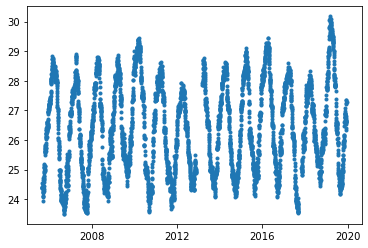

In [46]:
fig, ax = plt.subplots()
ax.plot(t, temp[:, 0], ".")

# Good example

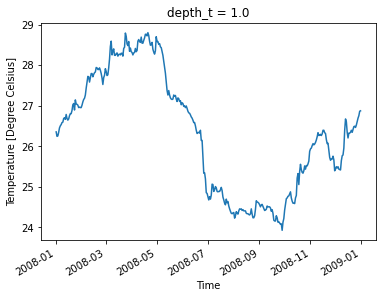

In [47]:
import xarray as xr

ds = xr.open_dataset(url)
temp = ds["temperature"]

temp.sel(depth_t=1.0, time="2008").plot();